In [1]:
import sys
sys.path.append('..')
from typing import Sequence
import tarfile
import io
import torch
import numpy as np
from omegaconf import DictConfig
from tqdm import tqdm
from datasets.video import OpticalFlowVideoDataset
import torch
from torchvision.utils import flow_to_image
from unittest.mock import MagicMock
import tqdm 
from algorithms.diffusion_forcing import DiffusionForcingFlow

import mediapy as media
from einops import rearrange

/home/iyu/miniconda3/envs/diff-force/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


49
type <class 'torch.Tensor'>
dataset item shapes torch.Size([1, 2, 256, 256]) torch.Size([1, 3, 256, 256]) (1,)
(256, 256, 3)
<class 'torch.Tensor'> <class 'torch.Tensor'>


""

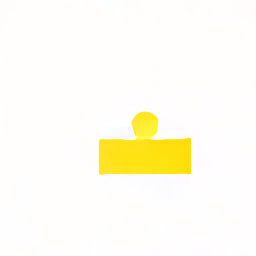

In [9]:
cfg = MagicMock()
cfg.resolution = 256
cfg.external_cond_dim = 0
cfg.n_frames = 1
cfg.frame_skip = 1
cfg.save_dir = "/home/iyu/diffusion-forcing/data/rod_flow"
cfg.validation_multiplier = 1
cfg.frame_stack = 1

dataset = OpticalFlowVideoDataset(cfg, "training")
print(len(dataset))

flow, vid, term = dataset[3]
print("dataset item shapes", flow.shape, vid.shape, term.shape)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=16)

data_mean = torch.tensor(0.5)
data_std = torch.tensor(0.5)

def _normalize_x(xs: torch.Tensor) -> torch.Tensor:
    shape = [1] * (xs.ndim - data_mean.ndim) + list(data_mean.shape)
    mean = data_mean.reshape(shape)
    std = data_std.reshape(shape)
    return (xs - mean) / std

def _unnormalize_x(xs: torch.Tensor) -> torch.Tensor:
    shape = [1] * (xs.ndim - data_mean.ndim) + list(data_mean.shape)
    mean = data_mean.reshape(shape)
    std = data_std.reshape(shape)
    return xs * std + mean

def _unstack_and_unnormalize(xs: torch.Tensor) -> torch.Tensor:
    xs = rearrange(xs, "t b (fs c) ... -> (t fs) b c ...", fs=1)
    return _unnormalize_x(xs)

vid_np = rearrange(vid[0] * 255, "c h w -> h w c").byte().numpy()
print(vid_np.shape)
print(type(vid), type(flow))

xs = _normalize_x(flow)
xs = rearrange(xs, "(t fs) c ... -> t (fs c) ...", fs=1).contiguous()
xs = _unstack_and_unnormalize(xs)

H, W = 256, 256
gt_img = flow_to_image(xs)
gt_img = torch.nn.functional.interpolate(gt_img, (H, W))

gt_img = rearrange(gt_img, "t c h w -> t h w c")
gt_img = gt_img[0].byte().numpy()
media.show_image(gt_img)